**BINARY LOGISTIC**

In [ ]:
# Import libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
# Load dataset

df = pd.read_csv("/content/Pharma_RealWorld_Regression_Dataset.csv")

print("Dataset dimensions:", df.shape)
print("\nFirst 5 rows of the dataset:")
print(df.head())
print("\nData types:")
print(df.dtypes)

Dataset dimensions: (200, 11)

First 5 rows of the dataset:
   Patient_ID  Age     Sex   BMI  Dose_mg Comorbidity Smoking_Status  \
0           1   63  Female  22.5       50          No        Current   
1           2   76    Male  26.6      100          No        Current   
2           3   53    Male  20.5       50         Yes         Former   
3           4   39  Female  22.9      100         Yes         Former   
4           5   67    Male  29.5      100         Yes        Current   

   Treatment_Duration_days  ADR_Occurrence  Time_to_ADR_days  Event  
0                       48               1                39      1  
1                       63               1                61      1  
2                       53               0               129      0  
3                       65               0                44      0  
4                       21               1                43      1  

Data types:
Patient_ID                   int64
Age                          int64
Sex 

In [ ]:
# Descriptive statisticsc

print(df.describe())
print("\nChecking for missing values")
print(df.isnull().sum())

       Patient_ID         Age         BMI     Dose_mg  \
count  200.000000  200.000000  200.000000  200.000000   
mean   100.500000   51.885000   26.662500   59.125000   
std     57.879185   15.805723    3.978276   27.702827   
min      1.000000   25.000000   17.600000   25.000000   
25%     50.750000   38.000000   24.100000   25.000000   
50%    100.500000   52.000000   26.400000   50.000000   
75%    150.250000   66.000000   29.525000   75.000000   
max    200.000000   79.000000   36.900000  100.000000   

       Treatment_Duration_days  ADR_Occurrence  Time_to_ADR_days      Event  
count               200.000000       200.00000         200.00000  200.00000  
mean                 62.265000         0.67500          55.02500    0.67500  
std                  33.992976         0.46955          41.46518    0.46955  
min                   7.000000         0.00000           0.00000    0.00000  
25%                  30.000000         0.00000          21.00000    0.00000  
50%               

In [ ]:
# 1. Check outcome distribution
print("ADR value counts:")
print(df["ADR_Occurrence"].value_counts())

# 2. Check unique values
print("\nUnique ADR values:")
print(df["ADR_Occurrence"].unique())

# 3. Check duplicate Patient_ID
print("\nDuplicate Patient IDs:", df["Patient_ID"].duplicated().sum())


ADR value counts:
ADR_Occurrence
1    135
0     65
Name: count, dtype: int64

Unique ADR values:
[1 0]

Duplicate Patient IDs: 0


In [ ]:
# CLASS IMBALANCE CHECK
print("Class proportion:")
print(df["ADR_Occurrence"].value_counts(normalize=True))


Class proportion:
ADR_Occurrence
1    0.675
0    0.325
Name: proportion, dtype: float64


In [ ]:
# REMOVING NON-PREDICTORS
df_model = df.drop(["Patient_ID", "Time_to_ADR_days", "Event"], axis=1)

print("Remaining columns:")
print(df_model.columns)


Remaining columns:
Index(['Age', 'Sex', 'BMI', 'Dose_mg', 'Comorbidity', 'Smoking_Status',
       'Treatment_Duration_days', 'ADR_Occurrence'],
      dtype='object')


In [ ]:
# Dependent variable
y = df_model["ADR_Occurrence"]

# Independent variables
X = df_model.drop("ADR_Occurrence", axis=1)

print("Target Variable:\n", y.head())
print("\nFeatures:\n", X.columns)


Target Variable:
 0    1
1    1
2    0
3    0
4    1
Name: ADR_Occurrence, dtype: int64

Features:
 Index(['Age', 'Sex', 'BMI', 'Dose_mg', 'Comorbidity', 'Smoking_Status',
       'Treatment_Duration_days'],
      dtype='object')


In [ ]:
# ENCODING CATEGORICAL VARIABLES

X_encoded = pd.get_dummies(X, drop_first=True)

print("Encoded columns:")
print(X_encoded.columns)


Encoded columns:
Index(['Age', 'BMI', 'Dose_mg', 'Treatment_Duration_days', 'Sex_Male',
       'Comorbidity_Yes', 'Smoking_Status_Former', 'Smoking_Status_Never'],
      dtype='object')


In [ ]:
# CHECKING FOR MULTICOLLINAERITY

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ensure numeric
X_vif = X_encoded.astype(float)

# Create VIF table
vif_data = pd.DataFrame()
vif_data["Feature"] = X_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_vif.values, i)
    for i in range(X_vif.shape[1])
]

print(vif_data)


                   Feature        VIF
0                      Age  11.316307
1                      BMI  18.014851
2                  Dose_mg   5.256200
3  Treatment_Duration_days   4.080130
4                 Sex_Male   1.851041
5          Comorbidity_Yes   1.894009
6    Smoking_Status_Former   2.198010
7     Smoking_Status_Never   3.530654


In [ ]:
# CORRECTING MULTICOLLINEARITY VIOLATION

X_reduced = X_encoded.drop(columns=["BMI"])

# Ensure all columns in X_reduced are numeric (float) before calculating VIF
X_reduced = X_reduced.astype(float)

# Recalculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_reduced.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_reduced.values, i)
    for i in range(X_reduced.shape[1])
]

print(vif_data)

                   Feature       VIF
0                      Age  7.344391
1                  Dose_mg  4.459526
2  Treatment_Duration_days  3.793564
3                 Sex_Male  1.799315
4          Comorbidity_Yes  1.874582
5    Smoking_Status_Former  2.027417
6     Smoking_Status_Never  3.232285


In [ ]:
# CHECKING FOR LINEARITY OF LOGIT

import numpy as np
import statsmodels.api as sm

# Create copy
df_bt = df.copy()

# Add log interaction terms
df_bt["Age_log"] = df_bt["Age"] * np.log(df_bt["Age"])
df_bt["Dose_mg_log"] = df_bt["Dose_mg"] * np.log(df_bt["Dose_mg"])
df_bt["Treatment_Duration_days_log"] = (
    df_bt["Treatment_Duration_days"] *
    np.log(df_bt["Treatment_Duration_days"])
)

# Prepare model data
df_bt_model = df_bt.drop(["Patient_ID", "Time_to_ADR_days", "Event", "BMI"], axis=1)

y_bt = df_bt_model["ADR_Occurrence"]
X_bt = df_bt_model.drop("ADR_Occurrence", axis=1)

X_bt = pd.get_dummies(X_bt, drop_first=True)

X_bt = X_bt.astype(float)

X_bt = sm.add_constant(X_bt)

model_bt = sm.Logit(y_bt, X_bt).fit()

print(model_bt.summary())


Optimization terminated successfully.
         Current function value: 0.568618
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:         ADR_Occurrence   No. Observations:                  200
Model:                          Logit   Df Residuals:                      189
Method:                           MLE   Df Model:                           10
Date:                Wed, 18 Feb 2026   Pseudo R-squ.:                 0.09826
Time:                        17:12:31   Log-Likelihood:                -113.72
converged:                       True   LL-Null:                       -126.12
Covariance Type:            nonrobust   LLR p-value:                  0.005768
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                          -0.9990      3.821     -0.261      0.794   

In [ ]:
# DATASET AFTER VIOLATION CORRECTION

# Remove non-predictors + BMI
df_final = df.drop(["Patient_ID", "Time_to_ADR_days", "Event", "BMI"], axis=1)

# Separate target and predictors
y = df_final["ADR_Occurrence"]
X = df_final.drop("ADR_Occurrence", axis=1)

# Encode categorical variables
X = pd.get_dummies(X, drop_first=True)

print("Final predictors:")
print(X.columns)


Final predictors:
Index(['Age', 'Dose_mg', 'Treatment_Duration_days', 'Sex_Male',
       'Comorbidity_Yes', 'Smoking_Status_Former', 'Smoking_Status_Never'],
      dtype='object')


In [ ]:
# Train and test split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42
)


In [ ]:
# STANDARDIZING

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit only on training data
X_train = scaler.fit_transform(X_train)

# Transform test data
X_test = scaler.transform(X_test)

In [ ]:
# Logistic regression

model = LogisticRegression(max_iter=1000,  class_weight="balanced")

model.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [ ]:
y_pred = model.predict(X_test)

# Probability predictions
y_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
# Evaluation metrics

print("Accuracy:", accuracy_score(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAUC Score:", roc_auc_score(y_test, y_prob))


Accuracy: 0.7166666666666667

Confusion Matrix:
[[10  4]
 [13 33]]

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.71      0.54        14
           1       0.89      0.72      0.80        46

    accuracy                           0.72        60
   macro avg       0.66      0.72      0.67        60
weighted avg       0.79      0.72      0.74        60


AUC Score: 0.7577639751552796


In [ ]:
# CROSS VALIDATION

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

pipeline = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=1000, class_weight="balanced")
)

cv_auc = cross_val_score(pipeline, X, y, cv=5, scoring="roc_auc")

print("Cross-validated AUC:", cv_auc.mean())


Cross-validated AUC: 0.645014245014245


In [ ]:
# ODDS RATIOS

import numpy as np
import pandas as pd

feature_names = X.columns

odds_ratios = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": model.coef_[0],
    "Odds_Ratio": np.exp(model.coef_[0])
})

print(odds_ratios.sort_values(by="Odds_Ratio", ascending=False))


                   Feature  Coefficient  Odds_Ratio
0                      Age     0.519746    1.681600
4          Comorbidity_Yes     0.197150    1.217927
3                 Sex_Male     0.157581    1.170675
2  Treatment_Duration_days     0.097226    1.102109
1                  Dose_mg    -0.179614    0.835592
6     Smoking_Status_Never    -0.277267    0.757852
5    Smoking_Status_Former    -0.336925    0.713963


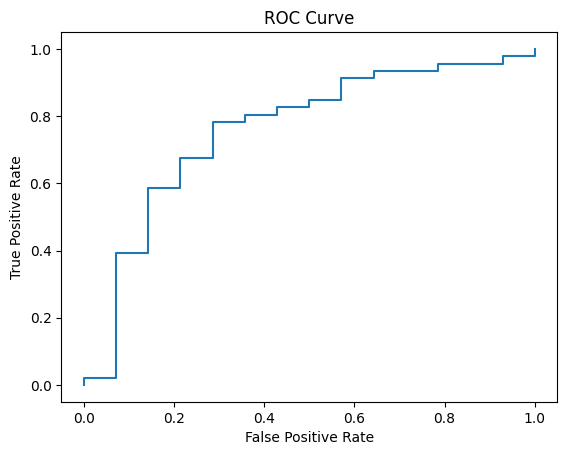

In [ ]:
# ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()
